# Reconstructing Trajectories with BSplines

In [ ]:
using TaD, Plots

## Example: Helix in 3-D


In [15]:
function helix(;Ω1::Tuple=(0.,4*π), Ω2::Tuple=(0.,4*π), n::Int64=100, α::Tuple=(1.,1.,1.))
    """
    Constructs nx3 Matrix [α1cos.(θ) α2sin.(θ), α3LinRange(Ω, n+1)]
    """
    arr = zeros(Float64, (n+1, 3))
    arr[:, 1] = α[1]*cos.(LinRange(Ω1[1], Ω1[2], n+1))
    arr[:, 2] = α[2]*sin.(LinRange(Ω2[1], Ω2[2], n+1))
    arr[:, 3] = α[3]*LinRange(0, Ω1[2]-Ω1[1], n+1)
    arr
end

helix (generic function with 1 method)

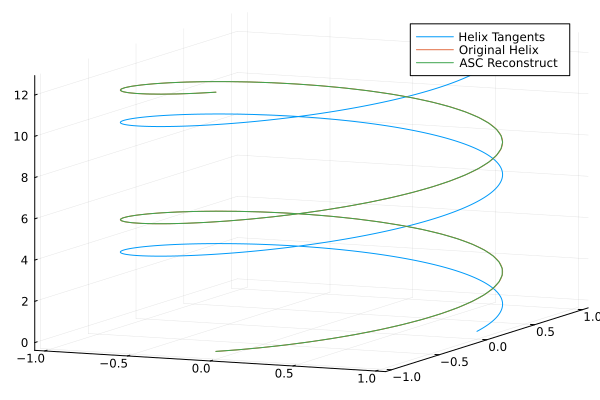

In [16]:
λ = helix(n=1000) #Helix Derivative
Λ = helix(Ω1=(-π/2, 4*π-π/2), Ω2=(π/2, 4*π+π/2), n=1000, α=(1,-1,1)) # Original Helix
tup = asc(λ[:,3], λ, [0.0,-1.,0.])
Curve = fit_bspline(hcat(tup[1], tup[2], λ[:,3]))

plot(tuple(λ[:,1], λ[:,2], λ[:,3]), label="Helix Tangents")
plot!(tuple(Λ[:,1], Λ[:,2], Λ[:,3]), label="Original Helix")
plot!(Curve, label="ASC Reconstruct")

#print("Error: ", norm(evaluate(Curve, length(λ[:,1])) - Λ))

## Example: Test data from Abughaban et al.

In [17]:
function asc_tangents(MD, θ, ϕ)
    λ_E   = sin.(ϕ) .* sin.(θ)
    λ_N   = sin.(ϕ) .* cos.(θ)
    λ_TVD = cos.(ϕ)
    return [λ_E λ_N λ_TVD] #x y z
end

asc_tangents (generic function with 1 method)

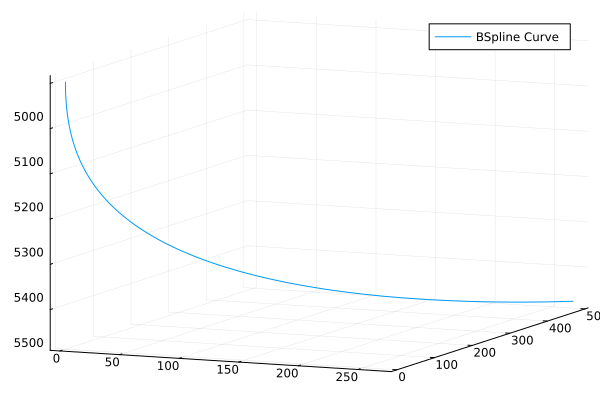

In [18]:
#Test data from Abughaban et al. https://onepetro.org/SPEDC/proceedings/16DC/3-16DC/Fort%20Worth,%20Texas,%20USA/207817
MD = collect(5000.:100.:5900.)
θ, ϕ = (2π/360) .* collect(0:5:45), (2π/360) .* collect(0:10:90)
λ = asc_tangents(MD, θ, ϕ)
Curve = reconstruct_trajectory(MD, λ, init=[0., 0., 5000.], p=3)
N = [0.00 8.69 34.29 75.46 130.05 195.24 267.75 344.03 420.52 493.85]
print(norm(evaluate(Curve, length(MD))[:,2] - N') < 1)